<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from datetime import datetime, timedelta
import pandas as pd
import os, time
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from datetime import datetime, timedelta
import pandas as pd
import os, time
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from keras.preprocessing.sequence import TimeseriesGenerator

In [49]:
ticker = "DIS"
look_back = 5 #  number of past days we want to use to predict 1 day in the future.
max_data_size = 730 # ~2 years
split_percent = 0.90 # use 90% of the data  for train
INFO = 1
DEBUG = 2
TRACE = 3
print_level = DEBUG 
indicators_model_file_path = '/content/drive/MyDrive/models/'+ticker+'_indicators_07.h5'
nr_of_indicators = 1
look_forward = 1
epochs = 200
learning_rate=0.0001
num_prediction = look_back * 3
np.random.seed(42)

In [50]:
rsi_url = 'https://www.alphavantage.co/query?function=RSI&datatype=json&symbol='+ticker+'&interval=daily&time_period=14&series_type=open&apikey=3F4URDEKOPLFH25T'
print(rsi_url)
rsi_api_response = pd.read_json(rsi_url)
#print(rsi_api_response)
rsi_api_data = rsi_api_response['Technical Analysis: RSI']
#print(rsi_api_data)
rsi_api_data = rsi_api_data.drop(
    index=['1: Symbol','2: Indicator','3: Last Refreshed','4: Interval','5: Time Period','6: Series Type','7: Time Zone']);
#print(rsi_api_data)

rsi_data = []
indicators_lstm_data = []
for key, value in rsi_api_data.items():
  date = key
  rsi = float(value.get('RSI'))
  rsi_data.append([date,rsi])
  indicators_lstm_data.append([rsi])

#print('rsi_data:', rsi_data)  
last_date =  str(rsi_data[0][0])

if max_data_size < len(rsi_data):
  rsi_data = np.flip(rsi_data[:max_data_size],axis=0)
  indicators_lstm_data = np.flip(indicators_lstm_data[:max_data_size],axis=0)
else:
  rsi_data = np.flip(rsi_data,axis=0)
  indicators_lstm_data = np.flip(indicators_lstm_data,axis=0)

first_rsi_data =  str(rsi_data[0])
last_rsi_data =  str(rsi_data[-1])
print('rsi_data_length:', len(rsi_data), 'first_rsi_data:', first_rsi_data, 'last_rsi_data:', last_rsi_data)  

https://www.alphavantage.co/query?function=RSI&datatype=json&symbol=DIS&interval=daily&time_period=14&series_type=open&apikey=3F4URDEKOPLFH25T
rsi_data_length: 730 first_rsi_data: ['2018-12-20' '34.5211'] last_rsi_data: ['2021-11-11' '34.5979']


In [51]:
indicators_df = pd.DataFrame(rsi_data,columns=['Date','RSI'])

split = int(split_percent*len(rsi_data))
if len(rsi_data) - split < look_back:
  split = look_back
split


indicators_df_train = indicators_df.iloc[:split]
indicators_df_test = indicators_df.iloc[split:]

indicators_lstm_train_data = indicators_lstm_data[:split]
indicators_lstm_test_data = indicators_lstm_data[split:]

In [52]:
np.set_printoptions(formatter={'float': '{: 0.12f}'.format})

indicators_scaler = MinMaxScaler(feature_range=(0, 1))
indicators_scaler = indicators_scaler.fit(indicators_lstm_data)

indicators_lstm_train_data_scaled = indicators_scaler.transform(indicators_lstm_train_data)
if print_level >= TRACE:
  print(indicators_lstm_train_data_scaled[:look_back+1])
  print(indicators_lstm_train_data_scaled.shape)

indicators_lstm_test_data_scaled = indicators_scaler.transform(indicators_lstm_test_data)
if print_level >= TRACE:
  print(indicators_lstm_test_data_scaled[:look_back+1])
  print(indicators_lstm_test_data_scaled.shape)

In [53]:
indicators_train_generator = TimeseriesGenerator(indicators_lstm_train_data_scaled, indicators_lstm_train_data_scaled, sampling_rate=1, length=look_back, batch_size=64)

if print_level >= TRACE:
  print('Samples: %d' % len(indicators_train_generator))
  # print each sample
  for i in range(2):
    x, y = indicators_train_generator[i]
    print('%s => %s' % (x, y))

In [54]:
indicators_model = None
try:
  indicators_model = keras.models.load_model(indicators_model_file_path)
  modified = os.path.getmtime(indicators_model_file_path)

  print(pd.to_datetime(last_date).date() - datetime.fromtimestamp(modified).date() )
  print('Loaded', indicators_model_file_path , ' model train date:',datetime.fromtimestamp(modified).date() , 'last date:', last_date)
except:
  indicators_model = None
  print('Model ' + indicators_model_file_path + ' does not exists.')

Model /content/drive/MyDrive/models/DIS_indicators_07.h5 does not exists.


Model /content/drive/MyDrive/models/DIS_indicators_07.h5 compiled.
Saved model /content/drive/MyDrive/models/DIS_indicators_07.h5


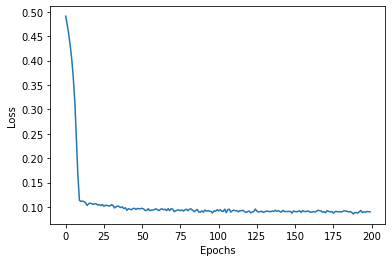

In [55]:
if indicators_model is None:
  indicators_model = Sequential()
  indicators_model.add(LSTM(units=50, activation='tanh', input_shape=(look_back, nr_of_indicators), return_sequences=True))
  indicators_model.add(Dropout(0.2))
  indicators_model.add(LSTM(units=50, return_sequences=True, activation="tanh"))
  indicators_model.add(Dropout(0.2))
  indicators_model.add(LSTM(units=50, return_sequences=True, activation="tanh"))
  indicators_model.add(Dropout(0.2))
  indicators_model.add(LSTM(units=50, activation="tanh"))
  indicators_model.add(Dropout(0.2))
  indicators_model.add(Dense(nr_of_indicators))

  indicators_model.compile(
      loss=MAE,
      optimizer=Adam(learning_rate=learning_rate),
      metrics=["mae"]
  )
    
  #model.summary()
  print('Model ' + indicators_model_file_path + ' compiled.')

  indicators_modelo = indicators_model.fit(indicators_train_generator, epochs=epochs, verbose=0 )
  
  indicators_model.save(indicators_model_file_path)
  print('Saved model ' + indicators_model_file_path)

  if print_level >= DEBUG:
    plt.plot(indicators_modelo.history['loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

In [56]:
indicators_test_generator = TimeseriesGenerator(indicators_lstm_test_data_scaled, indicators_lstm_test_data_scaled,sampling_rate=1, length=look_back, batch_size=look_back)

print('Samples: %d' % len(indicators_test_generator))
# print each sample
if print_level >= TRACE:
  for i in range(2):
    x, y = indicators_test_generator[i]
    print('%s => %s' % (x, y))

Samples: 14


In [57]:
#Make prediction
indicators_prediction_scaled = indicators_model.predict(indicators_test_generator)

if print_level >= DEBUG:
  np.set_printoptions(formatter={'float': '{: 0.12f}'.format})
  print(indicators_prediction_scaled[:5])

indicators_prediction = indicators_scaler.inverse_transform(indicators_prediction_scaled)

if print_level >= DEBUG:
  np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
  print('indicators_prediction shape:',indicators_prediction.shape)

  for x in range(look_back + 1):
    print('pred:',indicators_prediction[x], 'test:', indicators_lstm_test_data[x])


[[ 0.418218284845]
 [ 0.401756525040]
 [ 0.394941955805]
 [ 0.419765919447]
 [ 0.456682294607]]
indicators_prediction shape: (68, 1)
pred: [ 47.37] test: [ 49.23]
pred: [ 46.22] test: [ 47.00]
pred: [ 45.74] test: [ 41.11]
pred: [ 47.48] test: [ 41.10]
pred: [ 50.07] test: [ 51.07]
pred: [ 50.17] test: [ 50.27]


In [58]:
def predict(num_prediction, model):
    prediction_list = indicators_lstm_test_data_scaled[-look_back:]
    #print('prediction_list',prediction_list)
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        #print(x)
        x = x.reshape((1, look_back, nr_of_indicators))
        out = model.predict(x)
        #print(x,out) 
        prediction_list = np.append(prediction_list, out, axis=0)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(last_date,num_prediction):
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1,freq=us_bd).tolist()
    return prediction_dates

indicators_forecast_scaled = predict(num_prediction, indicators_model)
#print(forecast_scaled)
indicators_forecast_dates = predict_dates(indicators_df['Date'].values[-1],num_prediction)

indicators_forecast = indicators_scaler.inverse_transform(indicators_forecast_scaled.reshape((-1,nr_of_indicators)))
if nr_of_indicators == 1:
   indicators_forecast = indicators_forecast.reshape((-1))

print('indicators_forecast:',indicators_forecast)


indicators_forecast: [ 34.60  54.14  54.77  51.10  48.30  46.95  51.89  50.96  49.47  48.94
  49.33  50.33  49.74  49.32  49.33  49.54]


In [78]:
trace_train = go.Scatter(
  x = indicators_df_train['Date'],
  y = indicators_df_train['RSI'],
  mode='lines',
  name ='RSI'
)

trace_test = go.Scatter(
  x = indicators_df_test['Date'],
  y = indicators_df_test['RSI'],
  mode='lines',
  name ='RSI'
)

trace_prediction = go.Scatter(
    x = indicators_df_test['Date'],
    y = indicators_prediction.reshape((-1)),
    name ='Test'
)

trace_forecast = go.Scatter(
    x = indicators_forecast_dates,
    y = indicators_forecast,
    mode='lines',
    name ='RSI Forecast'
)


indicators_layout = go.Layout(
    xaxis = {'title' : "Dates"},
    yaxis = {'title' : "RSI"},
    height = 450
)

indicators_fig = go.Figure(data=[trace_train, trace_test,trace_prediction,trace_forecast], layout=indicators_layout)

indicators_fig.update_layout(shapes=[
dict(
  type= 'line',
  yref= 'y', y0= 30, y1= 30,   # adding a horizontal line at Y = 1
  xref= 'paper', x0= 0, x1= 1
  ) 
])

indicators_fig.update_yaxes(showspikes=True, spikemode='across', spikesnap='cursor',spikedash='dash')
indicators_fig.update_xaxes(showspikes=True, spikemode='across', spikesnap='cursor', spikedash='dash')
indicators_fig.update_layout(xaxis_rangeslider_visible=False)
config = dict({'scrollZoom': True})
indicators_fig.show(config=config)

indicators_fig.write_html('/content/drive/MyDrive/models/charts/'+ticker+ '_07_' + last_date + '_inidicators_forecast.html')

